In [1]:
import pandas as pd
import numpy as np
import os
import random

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.metrics import silhouette_score

In [2]:
# Load final exam and assignment data
data = pd.DataFrame(columns=['SubjectID', 'Assignment', 'CodeStateID'])
grades = {}
scores = {}
for directory in ['F19_All', 'S19_All']:
  base_path = os.path.join('data', directory, 'Train' if directory == 'F19_All' else '')
  grade_data = pd.read_csv(os.path.join(base_path, 'Data', 'LinkTables', 'Subject.csv'))
  for row in grade_data.itertuples():
    grades[row.SubjectID] = row._2 if directory == 'S19_All' else row._2 / 100
  main = pd.read_csv(os.path.join(base_path, 'Data', 'MainTable.csv'))
  for row in main[main['EventType'] == 'Run.Program'].itertuples():
    scores[row.CodeStateID] = row.Score
  main = main[(main['EventType'] == 'Compile') & (main['Compile.Result'] == 'Success')]
  main['Assignment'] = [f'{int(x[0])}-{int(x[1])}' for x in list(zip(main['AssignmentID'], main['ProblemID']))]
  data = pd.concat([data, main[['SubjectID', 'Assignment', 'CodeStateID']]], ignore_index=True)

data['Score'] = [scores[x] for x in data['CodeStateID']]
data['ExamGrade'] = [grades[x] if x in grades else 0 for x in data['SubjectID']]
data = data[data['Score'] == 1]
data.head()

,SubjectID,Assignment,CodeStateID,Score,ExamGrade
0,014604ba54339d4b1266cf78e125053a5ac11dd861ef3c...,439-1,79c9e2da9bc703116d8768297056db22866c43d583e529...,1.0,0.97
1,014604ba54339d4b1266cf78e125053a5ac11dd861ef3c...,439-3,0e91ae5696da0d6a724380360147b8699a25c14ff46227...,1.0,0.97
2,014604ba54339d4b1266cf78e125053a5ac11dd861ef3c...,439-5,1b38c7b1c7ebca281bbbc270d1b896484de663045c715f...,1.0,0.97
3,014604ba54339d4b1266cf78e125053a5ac11dd861ef3c...,439-12,2a850f5de4aaf278f5752896aaee2df171a4a5f284ec8b...,1.0,0.97
4,014604ba54339d4b1266cf78e125053a5ac11dd861ef3c...,439-13,7ec7412b1bf528ea84551d5ef407d4b1682132332245e4...,1.0,0.97


In [3]:
random.seed(1)
code_ids = data['CodeStateID']
assignments = data['Assignment']
assign_c = {}
unique_assignments = data['Assignment'].unique()
for assign in unique_assignments:
  assign_c[assign] = (random.random(), random.random(), random.random())
assign_lookup = {}
for c_id, assign in zip(code_ids, assignments):
  assign_lookup[c_id] = assign

In [4]:
def assign_colors(file, vector_size):
  frame = pd.read_csv(file)
  frame = frame[[x in assign_lookup for x in frame['CodeStateID']]]
  vectors = frame.iloc[:,0:vector_size]
  pca = PCA(random_state=1, n_components=2)
  pca.fit(vectors)
  vectors = pca.transform(vectors)
  plt.scatter(vectors[:,0], vectors[:,1], marker='.', s=1, c=[assign_c[assign_lookup[x]] for x in frame['CodeStateID']])
  plt.show()
  sill_scores = {'data/Vectors/deepwalk.csv': -0.25236, 'data/Vectors/code2vec.csv': -0.16918, 'data/Vectors/node2vec.csv': -0.25136, 'data/Vectors/tf_idf.csv': 0}
  print(f'Silhouette Score: {sill_scores[file]}')

In [5]:
def heat_map(file, vector_size):
  PROBLEMS = ['439-236', '487-20', '439-232', '439-234']
  random.seed(1)
  vector_map = {}
  frame = pd.read_csv(file)
  vectors = np.array(frame.iloc[:,0:vector_size])
  c_ids = frame['CodeStateID']
  for v, c in zip(vectors, c_ids):
    vector_map[c] = v
  NUM_VECTORS = 100
  filt = data[[x in vector_map for x in data['CodeStateID']]]
  chosen_vectors = []
  chosen_ids = []
  for problem in PROBLEMS:
    filt2 = filt[filt['Assignment'] == problem].reset_index()
    chosen_ids += random.sample(list(filt2['CodeStateID']), 10)
  chosen_vectors = [vector_map[x] for x in chosen_ids]
  distances = np.zeros((len(chosen_vectors), len(chosen_vectors)))
  for i in range(len(chosen_vectors)):
    for j in range(i, len(chosen_vectors)):
      dist = np.linalg.norm(chosen_vectors[i] - chosen_vectors[j])
      distances[i][j] = dist
      distances[j][i] = dist
  heatmap(distances)
  plt.show()
#   print(chosen_ids)

Ideal heat map


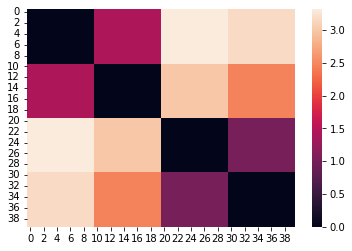

In [6]:
print("Ideal heat map")
vectors = []
distances = np.zeros((40, 40))
for i in range(10):
  vectors.append(np.array([0, 1, 1]))
for i in range(10):
  vectors.append(np.array([1, 2, 1]))
for i in range(10):
  vectors.append(np.array([3, 0, 0]))
for i in range(10):
  vectors.append(np.array([3, 1, 0]))
for i in range(len(vectors)):
  for j in range(i, len(vectors)):
    dist = np.linalg.norm(vectors[i] - vectors[j])
    distances[i][j] = dist
    distances[j][i] = dist
heatmap(distances)
plt.show()

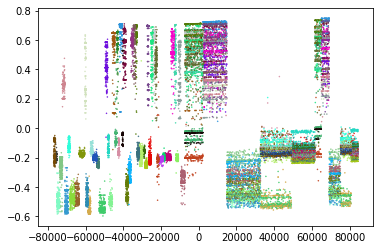

Silhouette Score: 0


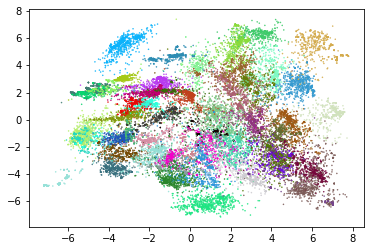

Silhouette Score: -0.16918


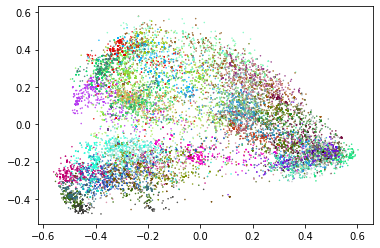

Silhouette Score: -0.25236


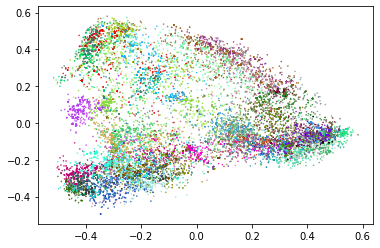

Silhouette Score: -0.25136


In [7]:
assign_colors('data/Vectors/tf_idf.csv', 50)
assign_colors('data/Vectors/code2vec.csv', 384)
assign_colors('data/Vectors/deepwalk.csv', 50)
assign_colors('data/Vectors/node2vec.csv', 50)

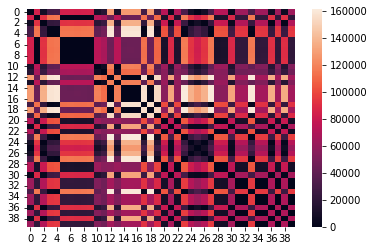

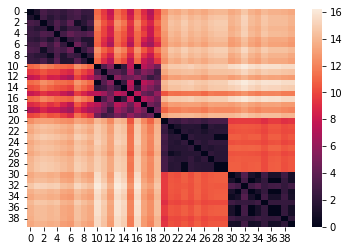

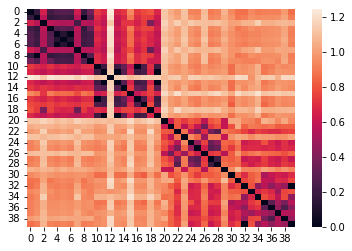

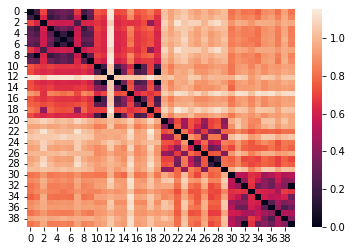

In [8]:
heat_map('data/Vectors/tf_idf.csv', 50)
heat_map('data/Vectors/code2vec.csv', 384)
heat_map('data/Vectors/deepwalk.csv', 50)
heat_map('data/Vectors/node2vec.csv', 50)